In [1]:
import random
import os

import matplotlib.pyplot as plt
import numpy as np
import torch

from src.data.augmenters import NoAugmenter, EigenAugmenter, MyAugmenter
from src.data.patch_samplers import NoPatchSampler, EigenPatchSampler, MyPatchSampler
from src.data.kitti_raw import KITTIRAWDataset

from src.models import CoarseFine
from src.models import MyModel

In [2]:
kitti_path: str = '/media/antonio/523f31c5-dc82-4dce-8457-65b5dd1f19e4/kitti'

In [3]:
dataset = KITTIRAWDataset(
        NoAugmenter(),
        NoPatchSampler(),
        kitti_path,
        'train',
        'png',
)

In [4]:
baseline_model = CoarseFine()
checkpoint_path = os.path.join("experiments", "eigen","checkpoints","model_6.pth")
baseline_model.load_state_dict(torch.load(checkpoint_path))

my_model = MyModel(True, 2)

Working on device: cuda:0
Unbatching...
Computing the first predictions...
Detecting points of interest...
Found 20 points of interest

Working on point (x=584, y=170)
Warp and crop...


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

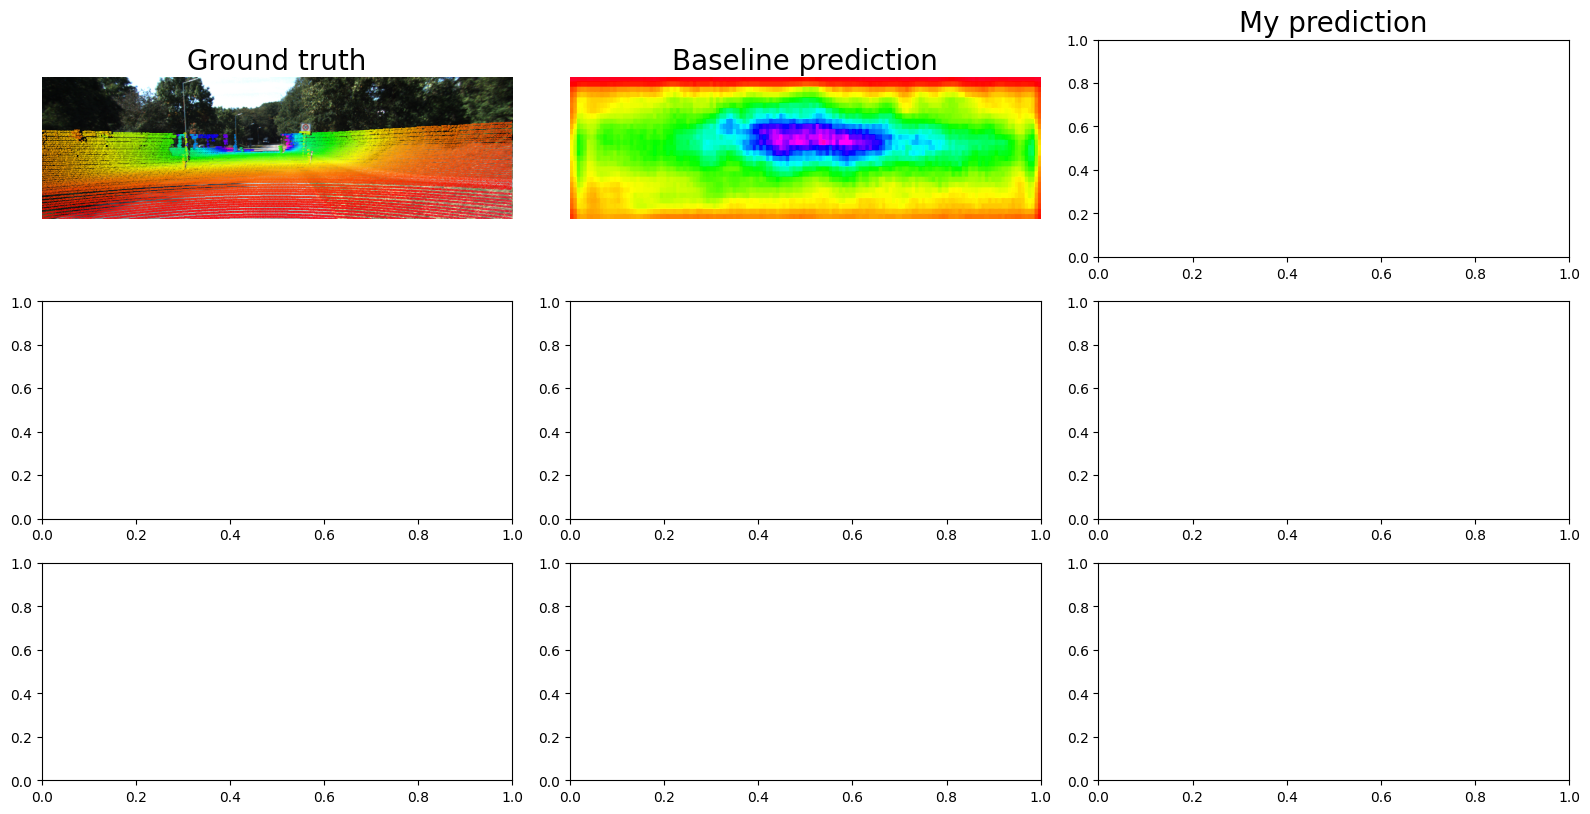

In [5]:
indices = random.choices(range(len(dataset)), k=6)
fig, axes = plt.subplots(3, 3, figsize=(16, 8))
plt.tight_layout()

axes[0, 0].set_title("Ground truth", fontsize=20)
axes[0, 1].set_title("Baseline prediction", fontsize=20)
axes[0, 2].set_title("My prediction", fontsize=20)
for i in range(3):
    image, depth_map, camera_parameters = dataset[indices[i]]
    
    # To cuda
    image = image.to('cuda')
    for k in camera_parameters:
        camera_parameters[k] = camera_parameters[k].to('cuda')

    # to numpy
    np_image = image[0].cpu().permute(1, 2, 0).numpy()
    np_depth_map = depth_map[0, 0].cpu().numpy()

    # Valid pixels
    yy, xx = np.nonzero(np_depth_map)

    axes[i, 0].axis("off")
    axes[i, 0].imshow(np_image)
    axes[i, 0].scatter(xx, yy, c=np_depth_map[yy, xx], s=0.1, cmap="gist_rainbow")

    # EIGEN
    baseline_model.to('cuda')
    baseline_model.eval()
    with torch.no_grad():
        pred = baseline_model(image, camera_parameters)
    np_pred = pred[0, 0].cpu().numpy()
    axes[i, 1].axis("off")
    axes[i, 1].imshow(np_pred, cmap="gist_rainbow")
    #axes[i, 1].scatter(xx, yy, c=np_pred[yy, xx], s=0.1, cmap="gist_rainbow")
    baseline_model.to('cpu')

    # MY MODEL
    my_model.to('cuda')
    my_model.eval()
    pred = my_model(image, camera_parameters)
    np_pred = pred[0, 0].cpu().numpy()
    print(f"depth map ranges in {np_depth_map.min():.2f}, {np_depth_map.max():.2f}")
    print(f"predicted depth map ranges in {np_pred.min():.2f}, {np_pred.max():.2f}\n")

    axes[i, 2].axis("off")
    axes[i, 2].imshow(np_pred, cmap="gist_rainbow")
    #axes[i, 2].scatter(xx, yy, c=np_pred[yy, xx], s=0.1, cmap="gist_rainbow")
    my_model.to('cpu')

plt.show()